In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


In [68]:
%matplotlib inline
from __future__ import division, print_function

In [3]:
import math
import numpy as np
import random
import sys

from numpy.random import normal
import matplotlib.pyplot as plt

In [69]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Embedding, Activation, merge, Flatten, Dropout, Lambda
from keras.layers import LSTM, SimpleRNN, TimeDistributed
from keras.models import Model, Sequential
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.constraints import nonneg
from keras.layers.convolutional import *
from keras import backend as K
from keras.utils.data_utils import get_file

In [70]:
# https://keras.io/getting-started/sequential-model-guide/

In [192]:
look_back = 15

In [193]:
model = Sequential()
model.add(LSTM(3, return_sequences=True, input_shape=(look_back, 1)))
#model.add(SimpleRNN(return_sequences=True, unroll=False, output_dim=1, input_dim=look_back))
#model.add(Dense(1))
#model.add(TimeDistributed(Dense(1)))
#model.compile(loss='mean_squared_error', optimizer='adam')

In [194]:
#print(dir(rnn))

In [195]:
def mllklh(args): # minus log-likelihood of gaussian
    var_t, eps2_t = args
    return 0.5*math.log(2*math.pi) + 0.5*K.log(var_t)  + 0.5*(eps2_t/var_t)

In [196]:
lag = 10

hdim = 1
    
inputs = [Input(shape=(1,), dtype='float32') for i in range(lag)]
    
Square = Lambda(lambda x:x*x, output_shape=(1,))

Di2h = Dense(hdim, activation=None)
Dh2h = Dense(hdim, activation=None, init='identity')

#hidden = ... CONSTANT ZERO TENSOR IN KERAS ?

e = Di2h(Square(inputs[0]))
hidden = e
for i in range(1,lag-1): # WARNING
    e = Di2h(Square(inputs[i]))
    hidden = merge([e, Dh2h(hidden)], mode='sum')
    
#predictions = Dense(len(chars), activation='softmax')(hidden)

predvar = Lambda(lambda x:K.abs(x)+0.000001, output_shape=(1,))([hidden]) # insure positive var
    
error = Lambda(mllklh, output_shape=(1,))([predvar,Square(inputs[-1])])

modelUNR = Model(inputs=inputs, outputs=error) # un-rolled model
    
def special_loss(dummy, errorterms):
        return errorterms

modelUNR.compile(optimizer=Adam(1e-3), loss=special_loss)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.


In [197]:
#len(Xs), Xs[0].shape, modelUNR.predict([X[10:15,0] for X in Xs]).shape

In [198]:
#modelUNR.predict([X[50:60,0] for X in Xs])

In [199]:
#modelUNRV = Model(input=inputs, output=predvar)
#np.sqrt(modelUNRV.predict([X[50:60,0] for X in Xs])*255)

In [200]:
#print(dir(rnn))
#rnn.output_shape, rnn.get_weights(), rnn.activation

In [251]:
I = Input(shape=(look_back,1), dtype='float32')
I2 = Lambda(lambda x : K.square(x), output_shape=(look_back,1))(I)
rnn = SimpleRNN(return_sequences=True, unroll=False,
                units=1, input_shape=(look_back, 1),
                bias_constraint=nonneg(), # insure positive var
                kernel_constraint=nonneg(), # insure positive var
                recurrent_constraint=nonneg(), # insure positive var
                activation=None) 
O1 = rnn(I2)
V = Lambda(lambda x : K.sqrt(x), output_shape=(look_back,1))(O1) # get volatility

Errors = Lambda(mllklh, output_shape=(look_back,1))([O1,I2])

Error = Lambda(lambda x : K.sum(x, axis=1), output_shape=(look_back,1))(Errors)

modelT = Model(inputs=I, outputs=Errors)

def special_loss(dummy, errorterms):
    return errorterms

modelT.compile(optimizer='adadelta', loss=special_loss)

modelV = Model(inputs=I, outputs=V)

In [252]:
I._keras_shape, I2._keras_shape, O1._keras_shape, V._keras_shape

((None, 15, 1), (None, 15, 1), (None, 15, 1), (None, 15, 1))

In [253]:
onearr = np.ones((2, look_back, 1)).astype('float32')
print(I2.eval({I:onearr}).shape)
print(O1.eval({I:onearr}).shape)
print(modelT.predict(onearr).shape)
print(modelV.predict(onearr).shape)

(2, 15, 1)
(2, 15, 1)
(2, 15, 1)
(2, 15, 1)


In [254]:
#model.predict(onearr).shape
Error.eval({I:onearr}).shape

(2, 1)

In [255]:
It = Input(shape=(look_back,1), dtype='float32')
RNNt = SimpleRNN(activation=None, return_sequences=True, unroll=False, units=1, input_shape=(look_back, 1))

RNNt(It).eval({It:onearr}) # dry run to allow weight setting

RNNt.set_weights([np.array([[0.5]]),np.array([[1.]]),np.array([3.])])
RNNt(It).eval({It:onearr})

array([[[  3.5],
        [  7. ],
        [ 10.5],
        [ 14. ],
        [ 17.5],
        [ 21. ],
        [ 24.5],
        [ 28. ],
        [ 31.5],
        [ 35. ],
        [ 38.5],
        [ 42. ],
        [ 45.5],
        [ 49. ],
        [ 52.5]],

       [[  3.5],
        [  7. ],
        [ 10.5],
        [ 14. ],
        [ 17.5],
        [ 21. ],
        [ 24.5],
        [ 28. ],
        [ 31.5],
        [ 35. ],
        [ 38.5],
        [ 42. ],
        [ 45.5],
        [ 49. ],
        [ 52.5]]], dtype=float32)

In [256]:
RNNt.states

[None]

In [257]:
modelT.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        (None, 15, 1)             0         
_________________________________________________________________
lambda_68 (Lambda)           (None, 15, 1)             0         
_________________________________________________________________
simple_rnn_24 (SimpleRNN)    (None, 15, 1)             3         
_________________________________________________________________
lambda_70 (Lambda)           (None, 15, 1)             0         
Total params: 3.0
Trainable params: 3.0
Non-trainable params: 0.0
_________________________________________________________________


In [258]:
kappa = 0.000003
alpha = 0.45
beta = 0.45
lvar = kappa / (1-alpha-beta)
print(math.sqrt(lvar)*math.sqrt(255))

0.0874642784227


In [259]:
rnn(I2).eval({I:onearr}) # dry run to allow weight setting
rnn.set_weights([np.array([[beta]]),np.array([[alpha]]),np.array([kappa])])

In [260]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#train = [math.sin(x*0.2) for x in range(250*3)]
train = []
trainvars = []
var_t = lvar
for t in range(250*8):
    eps = math.sqrt(var_t) * normal()
    var_t = kappa + alpha * var_t + beta * (eps*eps)
    train.append(eps) # percent
    trainvars.append(var_t)
train = np.array(train).reshape(-1,1)
trainX, trainY = create_dataset(train, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#print(trainX, trainY)

In [261]:
train[200:210,0], trainX.transpose((0,2,1))[(200,),:,:]

(array([-0.01184326,  0.00530252,  0.00033738,  0.00288079,  0.00873798,
         0.00898681,  0.00431205, -0.00623904, -0.0043565 , -0.00497749]),
 array([[[-0.01184326],
         [ 0.00530252],
         [ 0.00033738],
         [ 0.00288079],
         [ 0.00873798],
         [ 0.00898681],
         [ 0.00431205],
         [-0.00623904],
         [-0.0043565 ],
         [-0.00497749],
         [ 0.01005675],
         [ 0.00140008],
         [ 0.00517606],
         [-0.00168401],
         [ 0.00093824]]]))

In [262]:
var_t = lvar
for eps in train[0:200,0]:
    #eps = eps100/100
    var_t = kappa + alpha * var_t + beta * (eps*eps)
    #print(math.sqrt(var_t*255))
for eps in train[200:210,0]:
    #eps = eps100/250
    var_t = kappa + alpha * var_t + beta * (eps*eps)
    print(math.sqrt(var_t*255))

0.144222438989
0.115548460758
0.0823784722561
0.0690731489625
0.108043594279
0.123634767119
0.098879383427
0.0981397873753
0.085305292003
0.0829615926733


In [263]:
V.eval({I:trainX.transpose((0,2,1))[(200,),:,:].astype('float32')})*math.sqrt(255)

array([[[ 0.12984663],
        [ 0.10760327],
        [ 0.07738456],
        [ 0.06642342],
        [ 0.10729331],
        [ 0.12334038],
        [ 0.09871381],
        [ 0.09806474],
        [ 0.08526645],
        [ 0.08294363],
        [ 0.12436415],
        [ 0.08916184],
        [ 0.08612061],
        [ 0.06654293],
        [ 0.05346583]]], dtype=float32)

In [271]:
print( modelT.predict(trainX.transpose((0,2,1))[(1,300),:,:]) )
print('-------------------------')
print( modelV.predict(trainX.transpose((0,2,1))[(200,),:,:])*math.sqrt(255) )
print('-------------')
#np.sqrt(Model(input=I, output=O1).predict(trainX.transpose((0,2,1))[(200,),:,:])*255.)

[[[-2.83916068]
  [-2.66094041]
  [-2.59051728]
  [-2.50695157]
  [-2.53514338]
  [-2.54960489]
  [-2.54270196]
  [-2.51829529]
  [-2.541677  ]
  [-2.55413222]
  [-2.55593967]
  [-2.55627847]
  [-2.55846691]
  [-2.5538373 ]
  [-2.55017853]]

 [[-2.83547115]
  [-2.66120768]
  [-2.59945178]
  [-2.57433581]
  [-2.56537199]
  [-2.56089306]
  [-2.54459977]
  [-2.55764437]
  [-2.55697846]
  [-2.55592465]
  [-2.54538679]
  [-2.54877329]
  [-2.55734706]
  [-2.54692984]
  [-2.55596328]]]
-------------------------
[[[ 0.39244205]
  [ 0.45573479]
  [ 0.47714999]
  [ 0.48706293]
  [ 0.49912265]
  [ 0.50473839]
  [ 0.50009888]
  [ 0.5004068 ]
  [ 0.49826032]
  [ 0.49799556]
  [ 0.50655818]
  [ 0.49899387]
  [ 0.49854335]
  [ 0.49559796]
  [ 0.4940953 ]]]
-------------


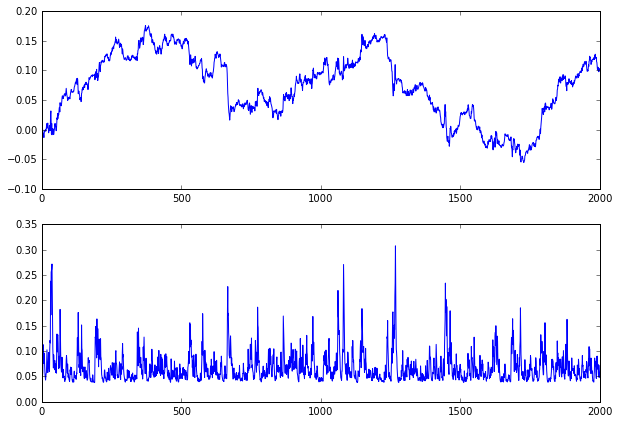

In [265]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(np.cumsum(train))
plt.subplot(2,1,2)
plt.plot(np.sqrt(trainvars)*math.sqrt(255))
plt.show()

In [266]:
trainX.shape, trainY.shape, trainX.transpose((0,2,1)).shape

((1984, 1, 15), (1984,), (1984, 15, 1))

In [281]:
#modelT.fit(trainX, trainY, nb_epoch=100, batch_size=50, verbose=1)

modelT.fit(trainX.transpose((0,2,1)), trainX.transpose((0,2,1)), epochs=1, batch_size=64, verbose=1)

Epoch 1/1
1984/1984 [==============================] - 0s - loss: -3.1174     


In [292]:
math.sqrt(rnn.get_weights()[2][0]/(1-rnn.get_weights()[0][0][0]-rnn.get_weights()[1][0][0])*255)

0.6991640227251201

In [280]:
idx = train

Xs = []
for l in range(lag):
    cdat = [idx[i+l] for i in xrange(0, len(idx)-1-lag, lag)]
    X = np.stack(cdat[:-2])
    Xs.append(X)

cdat = [idx[i+(l+1)] for i in xrange(0, len(idx)-1-lag, lag)]
Y = np.stack(cdat[:-2])

len(Xs), Xs[0].shape

(10, (197, 1))

In [269]:
modelUNR.optimizer.lr = 1e-2
dummy_Y = Xs[0]
hist1 = modelUNR.fit(Xs, dummy_Y, batch_size=40, nb_epoch=25)

Epoch 1/25
197/197 [==============================] - 0s - loss: -0.5005     
Epoch 2/25
197/197 [==============================] - 0s - loss: 0.5301     
Epoch 3/25
197/197 [==============================] - 0s - loss: 0.5685     
Epoch 4/25
197/197 [==============================] - 0s - loss: 0.5472     
Epoch 5/25
197/197 [==============================] - 0s - loss: 0.5048     
Epoch 6/25
197/197 [==============================] - 0s - loss: 0.4545     
Epoch 7/25
197/197 [==============================] - 0s - loss: 0.4025     
Epoch 8/25
197/197 [==============================] - 0s - loss: 0.3520     
Epoch 9/25
197/197 [==============================] - 0s - loss: 0.3045     
Epoch 10/25
197/197 [==============================] - 0s - loss: 0.2605     
Epoch 11/25
197/197 [==============================] - 0s - loss: 0.2202     
Epoch 12/25
197/197 [==============================] - 0s - loss: 0.1834     
Epoch 13/25
197/197 [==============================] - 0s - loss: 0.1499

In [27]:
lag = look_back

In [28]:
def show_top_next(mdl, inp, steps=1):
    inp = np.copy(inp)
    for k in range(steps):
        #ps = mdl.predict([np.array([i]) for i in inp])
        ps = mdl.predict(inp)
        newimp = np.concatenate((inp[0,:,:],ps), axis=1)
        inp[0,:,:] = newimp[:,1:]
    return inp

In [29]:
cut = 10
inps = [trainX[10:(cut+1),:,:], ]
for iter in range(8):
    inps.append( show_top_next(model, inps[-1], 5) )

print(inps[0])
print(inps[1])
print(inps[2])

[[[  2.88649919e-03  -2.74783844e-03   1.63140704e-05   3.59496255e-03
     1.68552216e-03]]]
[[[ 0.00037702 -0.00392252  0.00106558  0.00168964  0.00305192]]]
[[[-0.00242589 -0.00211503 -0.00037546  0.00334426  0.0013412 ]]]


In [13]:
TSmodel = np.concatenate(inps, axis=2)[0,0]
TSreal = trainX[range(cut,cut+5*len(inps),5),:,:].reshape((1,1,-1))[0,0]

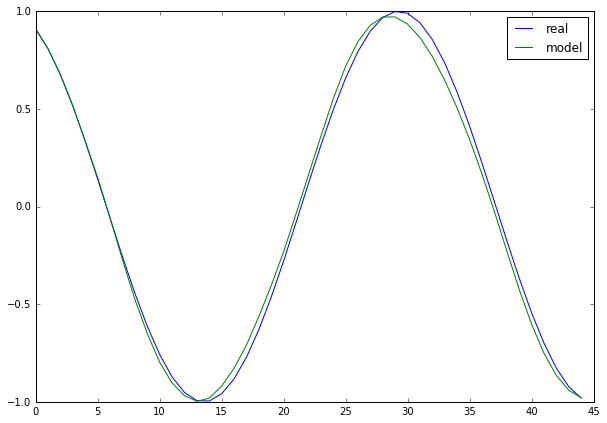

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(TSreal)
plt.plot(TSmodel)
plt.legend(['real','model'], loc='upper right')
plt.show()